# Transfer Learning for Color MNIST
### By Tomas Ward
Using a pretrained ResNet model and retraining some layers for the Color MNIST dataset

In [70]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3)) # 32x32 is a compatible size for this model


In [71]:
# Freeze 100 initial layers
for layer in base_model.layers[1:120]:
    layer.trainable = False

base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 17,215,488 (65.67 MB)

 Non-trainable params: 6,372,224 (24.31 MB)

In [72]:
# As we are classifying digits, the output needs to change. The input can still be the same.
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)  # Final layer for 10 classes (0-9 digits)

new_model = Model(inputs=base_model.input, outputs=output)
optimizer = Adam(learning_rate=1e-4)
new_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
# Load the data
import os
import numpy as np
from PIL import Image

# Function to load images from labeled folders
def load_images(data_dir):
    labels = []
    images = []
    classes = sorted(os.listdir(data_dir))  # Get the folders/classes (labels)

    # Loop through all folders
    for idx, class_name in enumerate(classes):
        class_folder = os.path.join(data_dir, class_name)
        print('Loading class %s' %class_name)
        
        if os.path.isdir(class_folder):
            # Loop through each image file within the class folder
            for img_name in os.listdir(class_folder)[0:1000]:
                img_path = os.path.join(class_folder, img_name)

                try:
                    # Load the image, resize it, and convert to a numpy array
                    img = Image.open(img_path)
                    img_array = np.array(img)

                    # Add the image to the list and its corresponding label (class index)
                    images.append(img_array)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels, classes

# Specify the directory where images are stored
# note: you may need to use the function more than once to load the training/testing dataset
data_dir_train = '../data/MNIST-M/training'
data_dir_test = '../data/MNIST-M/testing'

# Call the function to load images and labels
train_images, train_labels, train_classes = load_images(data_dir_train)
test_images, test_labels, test_classes = load_images(data_dir_test)


print(f"Loaded trian_images: {train_images.shape}")
print(f"Loaded train_labels: {train_labels.shape}")
print(f"train_Classes: {train_classes}")

print(f"Loaded test_images: {test_images.shape}")
print(f"Loaded test_labels: {test_labels.shape}")
print(f"test_Classes: {test_classes}")

Loading class 0
Loading class 1
Loading class 2
Loading class 3
Loading class 4
Loading class 5
Loading class 6
Loading class 7
Loading class 8
Loading class 9
Loading class 0
Loading class 1
Loading class 2
Loading class 3
Loading class 4
Loading class 5
Loading class 6
Loading class 7
Loading class 8
Loading class 9
Loaded trian_images: (10000, 32, 32, 3)
Loaded train_labels: (10000,)
train_Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Loaded test_images: (8985, 32, 32, 3)
Loaded test_labels: (8985,)
test_Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [74]:
# Data processing
train_images, test_images = train_images / 255.0, test_images / 255.0 #Normalize pixels

# One-hot encode the labels
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [75]:
# Plot Losses callback
import matplotlib.pyplot as plt
from IPython.display import clear_output
import keras


class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val-loss")
        plt.legend()
        plt.show()


plot_losses = PlotLosses()

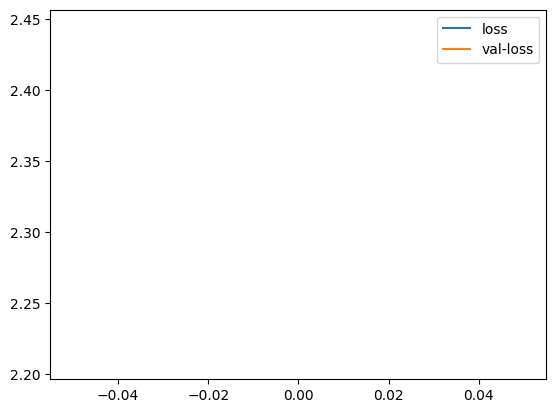

157/157 ━━━━━━━━━━━━━━━━━━━━ 96s 588ms/step - accuracy: 0.1606 - loss: 2.3616 - val_accuracy: 0.1289 - val_loss: 2.4449
Epoch 2/20
 93/157 ━━━━━━━━━━━━━━━━━━━━ 36s 571ms/step - accuracy: 0.3347 - loss: 1.9094

In [ ]:
# Train the model. Only the upper layers will be trained and learn about the specific
# characteristics of the Color MNIST dataset
history = new_model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(test_images, test_labels),callbacks=[plot_losses])

In [ ]:
test_loss, test_acc = new_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")


281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.2861 - loss: 5.4729
Test Accuracy: 0.32854756712913513


ChatGPT was used to get code ideas or reformat code. The concepts were incorporated and all written code is understood and tested.